# UNet Model 

### Define Environment Variables and Hyper Parameters

In [1]:
import os
import time
import h5py
import torch
import numpy as np
# from unet import ConvBlock, UnetModel
from functions import transforms as T
from functions.subsample import MaskFunc
from torch import nn
from torch.nn import Conv2d, Sequential, InstanceNorm2d, ReLU, Dropout2d, Module, ModuleList, functional as F
from torch.utils.data import DataLoader
from torch.optim import RMSprop
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from scipy.io import loadmat
from skimage.measure import compare_ssim 
from matplotlib import pyplot as plt

In [83]:
# labs
data_path_train = '/data/local/NC2019MRI/train'
data_path_test = '/data/local/NC2019MRI/test'
# windows - change as req
# data_path_train = r'../NC2019MRI/train'
# data_path_test = r'../NC2019MRI/test'

# 0.2 = split training dataset into 20% validation data, 80% training data
train_val_split = 0.2

# for mask 4AF - acc = 4, cen = 0.08
# acc = 4
# cen_fract = 0.08
# for mask 8AF - acc = 8, cen = 0.04
acc = 8
cen_fract = 0.04
seed = True # random masks for each slice 
num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data

# Model parameters
in_chans = 1
out_chans = 1
chans = 8
# This needs to be (1,1) for the model to run...why...
kernel_size=(1, 1)

# Hyperparameters
epochs = 20
dropout_prob = 0.001
learning_rate = 0.001
weight_decay = 0.0
step_size = 15
lr_gamma = 0.1 # change in learning rate
num_pool_layers = 3

# Check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

### Data Visualisation

In [84]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

### Data Loading and Processing

In [85]:
def load_data_path(train_data_path):
#     eventually make this random subsets by shuffling data for
    """ Go through training data path, list all file names, the file paths and the slices of subjects. 
    Split into training and validation set depending on value of train_val_split
    """
    train_files = []
    val_files = []
    
    files = len(os.listdir(train_data_path))
    train_files_num = (1 - train_val_split) * files
#     val_files_num = train_val_split * files
    i = 0    
    for fname in sorted(os.listdir(train_data_path)):
        subject_data_path = os.path.join(train_data_path, fname)
        if not os.path.isfile(subject_data_path): continue 
        
        if i <= train_files_num:
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]        
                # the first 5 slices are mostly noise so it is better to exlude them
                train_files += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
        elif i > train_files_num:
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]        
                # the first 5 slices are mostly noise so it is better to exlude them
                val_files += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
        i += 1
        
    return train_files, val_files

In [86]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed):
    ''' random select a few slices (batch_size) from each volume'''
    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]             
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape
    
    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: 
        norm = 1e-6
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

In [87]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

## Model

- Unet: Neural networks with downsampling and upsampling. ref: https://github.com/facebookresearch/fastMRI/blob/master/models/unet/

In [88]:
class UnetModel(Module):
    """
    PyTorch implementation of a U-Net model.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob, kernel_size):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob
        self.kernel_size = kernel_size

        self.down_sample_layers = ModuleList([ConvBlock(in_chans, chans, drop_prob, kernel_size)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob, kernel_size)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob, kernel_size)

        self.up_sample_layers = ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob, kernel_size)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob, kernel_size)]
        self.conv2 = Sequential(
            Conv2d(ch, ch // 2, kernel_size=1),
            Conv2d(ch // 2, out_chans, kernel_size=1),
            Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [89]:
class ConvBlock(Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """
    
    def __init__(self, in_chans, out_chans, drop_prob, kernel_size):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob
        self.kernel_size = kernel_size

        self.layers = Sequential(
            Conv2d(in_chans, out_chans, kernel_size=self.kernel_size),
            InstanceNorm2d(out_chans),
            ReLU(),
            Dropout2d(drop_prob),
            Conv2d(out_chans, out_chans, kernel_size=self.kernel_size),
            InstanceNorm2d(out_chans),
            ReLU(),
            Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args: input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns: (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

    # def __repr__(self):
    #     return ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, drop_prob={self.drop_prob})

## Main Methods

In [90]:
def training_epoch(epoch, model, data_loader, optimizer):
    model.train()
    avg_loss = 0
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    
    for iter, data_sample in enumerate(data_loader):
        # img ground truth, img undersampled, raw data understampled, masks, norm
        img_gt, img_und, rawdata_und, masks, norm = data_sample
        input = T.complex_abs(img_und)
        input = T.center_crop(input, [320, 320])
        input = input[None, ...].to(device, dtype=torch.float)
        
        target = T.complex_abs(img_gt)
        target = T.center_crop(target, [320, 320])
        target = target[None, ...].to(device, dtype=torch.float)

        output = model(input)
        loss = F.l1_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        start_iter = time.perf_counter()
        
    return avg_loss, time.perf_counter() - start_epoch
    

In [91]:
def validation_epoch(epoch, model, data_loader, optimizer):
    model.train()
    avg_loss = 0
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    
    for iter, data_sample in enumerate(data_loader):
        # img ground truth, img undersampled, raw data understampled, masks, norm
        img_gt, img_und, rawdata_und, masks, norm = data_sample
        input = T.complex_abs(img_und) # absolute values
        input = T.center_crop(input, [320, 320]) # crop to 320  x 320
        input = input[None, ...].to(device, dtype=torch.float) # 3d to 4d tensor
        
        target = T.complex_abs(img_gt)
        target = T.center_crop(target, [320, 320])
        target = target[None, ...].to(device, dtype=torch.float)

        output = model(input)
        loss = F.l1_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        start_iter = time.perf_counter()
        
    return avg_loss, time.perf_counter() - start_epoch
    

In [92]:
if __name__ == '__main__':       
    train_data, val_data  = load_data_path(data_path_train) # first load all file names, paths and slices.

    # create data loader for training and validation sets
    train_dataset = MRIDataset(train_data, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 

    val_dataset = MRIDataset(val_data, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    # create model object
    model = UnetModel(in_chans=in_chans, out_chans=out_chans, chans=chans, num_pool_layers=4, drop_prob=dropout_prob, kernel_size=kernel_size).to(device)
    # use RMSprop as optimizer
    optimizer = RMSprop(model.parameters(), learning_rate, weight_decay=weight_decay)

In [93]:
# input_size=(channels, H, W)
summary(model, input_size=(1, 320, 320), batch_size=1, device=str(device))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 8, 320, 320]              16
    InstanceNorm2d-2           [1, 8, 320, 320]               0
              ReLU-3           [1, 8, 320, 320]               0
         Dropout2d-4           [1, 8, 320, 320]               0
            Conv2d-5           [1, 8, 320, 320]              72
    InstanceNorm2d-6           [1, 8, 320, 320]               0
              ReLU-7           [1, 8, 320, 320]               0
         Dropout2d-8           [1, 8, 320, 320]               0
         ConvBlock-9           [1, 8, 320, 320]               0
           Conv2d-10          [1, 16, 160, 160]             144
   InstanceNorm2d-11          [1, 16, 160, 160]               0
             ReLU-12          [1, 16, 160, 160]               0
        Dropout2d-13          [1, 16, 160, 160]               0
           Conv2d-14          [1, 16, 1

In [94]:
# Epochs
scheduler = StepLR(optimizer, step_size, lr_gamma)
current_epoch = 0
# record loss overtime for plotting
train_loss_ot = []
val_loss_ot = []

print("Training on " + str(len(train_data)))
print("Validating on " + str(len(val_data)))
    
# run model epochs
for epoch in range(current_epoch, epochs):
    scheduler.step(epoch)
    print("Epoch: " + str(epoch+1) + "/" + str(epochs))
    train_loss, train_time = training_epoch(epoch, model, train_loader, optimizer)
    val_loss, val_time = validation_epoch(epoch, model, val_loader, optimizer)
    train_loss_ot.append(train_loss)
    val_loss_ot.append(val_loss)
    print(" Train Loss: " + str(train_loss) + " | Validation Loss: " + str(val_loss))
    print("Train Time: " + str(train_time) + " | Validation Time: " + str(val_time))

Training on 1714
Validating on 420
Epoch: 1/20
 Train Loss: 0.08017883475261241 | Validation Loss: 0.07722513851377855
Train Time: 43.912557292031124 | Validation Time: 11.322149015963078
Epoch: 2/20
 Train Loss: 0.07496281865262786 | Validation Loss: 0.07336352825101866
Train Time: 44.13256138609722 | Validation Time: 11.37965878401883
Epoch: 3/20
 Train Loss: 0.0735501636566242 | Validation Loss: 0.07268417314344036
Train Time: 44.24089343100786 | Validation Time: 11.332404565997422
Epoch: 4/20
 Train Loss: 0.07232924327899953 | Validation Loss: 0.07339268747264399
Train Time: 44.77421961806249 | Validation Time: 11.443333951057866
Epoch: 5/20
 Train Loss: 0.07300845130510654 | Validation Loss: 0.07171442144068674
Train Time: 44.64151468104683 | Validation Time: 11.472441095975228
Epoch: 6/20
 Train Loss: 0.06942566106052642 | Validation Loss: 0.06938785230150703
Train Time: 44.60896102001425 | Validation Time: 11.41010370303411
Epoch: 7/20
 Train Loss: 0.07253728429997751 | Validati

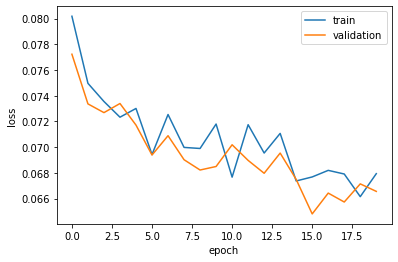

In [95]:
plt.plot(train_loss_ot, label='train')
plt.plot(val_loss_ot, label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss' + '.png')
plt.show()

### Test Model

In [104]:
data_sample = next(iter(train_loader))
# img ground truth, img undersampled, raw data understampled, masks, norm
img_gt, img_und, rawdata_und, masks, norm = data_sample
img_und = T.complex_abs(img_und)
img_und_cropped = T.center_crop(img_und, [320, 320])
img_und_padded = img_und_cropped[None, ...].to(device, dtype=torch.float)

pred = model(img_und_padded)

TypeError: 'int' object is not callable

In [105]:
img_gt = T.complex_abs(img_gt)
img_gt_cropped = T.center_crop(img_gt, [320,320])
img_gt_2d = img_gt_cropped[-1,:,:]

# img_und = T.complex_abs(img_und)
img_und_cropped = T.center_crop(img_und, [320,320])
# to 2s
img_und_2d = img_und_cropped[-1,:,:]

# bring to cpu
predc = pred.cpu().detach()
# prediction 4d -> 3d
pred3d = predc[-1,:,:,:]
# prediction 3d -> 2d
pred2d = predc[-1,-1,:,:]

print(img_gt_2d.shape)
print(img_und_2d.shape)
print(pred2d.shape)
all_imgs = torch.stack([img_und_2d,img_gt_2d, pred2d], dim=0)
show_slices(all_imgs, [0,1,2], cmap='gray')

AssertionError: 

### Get results from training and validation data

In [99]:
gts = []
preds = []

for iter, data_sample in enumerate(train_loader):
    # img ground truth, img undersampled, raw data understampled, masks, norm
    img_gt, img_und, rawdata_und, masks, norm = data_sample
    img_und = T.complex_abs(img_und)
    img_und_cropped = T.center_crop(img_und, [320, 320])
    img_und_padded = img_und_cropped[None, ...].to(device, dtype=torch.float)

    pred = model(img_und_padded)

    img_gt = T.complex_abs(img_gt)
    img_gt_cropped = T.center_crop(img_gt, [320,320])

    # bring to cpu
    predc = pred.cpu().detach()
    # prediction 4d -> 3d
    pred3d = predc[-1,:,:,:]
    # prediction 3d -> 2d
    pred2d = predc[-1,-1,:,:]
    
    gts.append(img_gt_cropped.numpy())
    preds.append(pred3d.numpy())

for iter, data_sample in enumerate(val_loader):
    # img ground truth, img undersampled, raw data understampled, masks, norm
    img_gt, img_und, rawdata_und, masks, norm = data_sample
    img_und = T.complex_abs(img_und)
    img_und_cropped = T.center_crop(img_und, [320, 320])
    img_und_padded = img_und_cropped[None, ...].to(device, dtype=torch.float)

    pred = model(img_und_padded)

    img_gt = T.complex_abs(img_gt)
    img_gt_cropped = T.center_crop(img_gt, [320,320])

    # bring to cpu
    predc = pred.cpu().detach()
    # prediction 4d -> 3d
    pred3d = predc[-1,:,:,:]
    # prediction 3d -> 2d
    pred2d = predc[-1,-1,:,:]
    
    gts.append(img_gt_cropped.numpy())
    preds.append(pred3d.numpy())

## Evaluation on training data
We can evaluate SSIM on the whole volume in the region of interset (320x320 central region) with respect to ground truth. As can be seen, the more aggressive sampling we have, the lower SSIM value we get. 

In [100]:
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). Required 3D input np arrays"""
    return compare_ssim(
        gt.transpose(1,2,0), pred.transpose(1,2,0), multichannel=True, data_range=gt.max()
    )

In [101]:
length = len(gts)
i = 0
ssim_comb = 0
for i in range(0,length):
    ssim_comb += ssim(gts[i], preds[i])

ssim = ssim_comb / length

print("Average SSIM: " + str(ssim))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


Average SSIM: 0.4686312791624842
